# correction time evolution
### JAH 4/8/18

<i>
This notebook studies the corrections (lifetime map and escale) evolution along time for a given run.

It can produce a movie (gif) for the escale and lifetime map evolutions (but it needs a plots folder and the imageio module, uncomment the include of movie_functions).
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Wed Oct  3 16:39:50 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number                 = 6345
input_dst_filenames        = [f"$IC_DATA/{run_number}/dsts/kdst_{run_number}_filtered.h5"]
# bootstrap correction
run_number_correction      = run_number
correction_filename        = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"

apply_geocorrection = True
delta_time          = 1.   # map every hour
make_movie          = True

Rrange  =    0., 180.
Zrange  =    0., 550.
XYrange = -200., 200.

XYnbins_fine = 100
XYnbins      =  40

E0range = 6.5e3, 13.5e3
LTrange = 2.5e3,  6.0e3
E0urange =  10., 60.
LTurange =  10., 400.

QE0range = 0.4e3, 0.75e3
QLTrange = 1.0e3, 4.0e3
QE0urange =  12., 60.
QLTurange =  20., 400.


### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
from invisible_cities.core .core_functions import in_range

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.utils.hst_extend_functions   as hst
import krcal.utils.plt_functions          as apt
import krcal.utils.kdst_functions         as kdstf
import krcal.utils.movie_functions        as mv
import krcal.dev.akr_functions            as akr
import krcal.dev.corrections              as corrections

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
input_dst_filenames = [os.path.expandvars(fi) for fi in input_dst_filenames]
correction_filename = os.path.expandvars(correction_filename)

In [7]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [8]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1054737 
Total number of events: 1054737


## Relevant data and corrections

In [9]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
TD  = np.array([datetime.datetime.fromtimestamp(itime) for itime in T])
TH  = (T - T.min())/3600. # time in hours

In [10]:
if (apply_geocorrection):
    print('Applying geometrical corrections: E, Q')
    calibrate = corrections.Calibration(correction_filename)
    E, Q = calibrate(X, Y, None, T, S2e, S2q)
else:
    E, Q = S2e, S2q

Applying geometrical corrections: E, Q
calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/kr_corrections_run6345.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 3601.3 (us) 
Charge   scale :  1.0 (pes)


## Global lifetime

In [11]:
sel_r = in_range(R, *Rrange)
sel_z = in_range(Z, *Zrange)
sel   = sel_r & sel_z

In [12]:
Znbins = 50
Enbins, Erange = 50, (6e3, 14e3)

In [13]:
e0, lt, chi2, ok = akr.lt_lsqfit(Z[sel], E[sel], nbins=Znbins)
print('e0, lt  (unbinned)', e0.value, lt.value, ' chi2 ', chi2)

e0, lt  (unbinned) 10197.97772907406 3702.5532018482936  chi2  10.334717152672384


e0, lt  (binned)  [10198.43851336 -3711.15870504] chi2 9.549384485684465


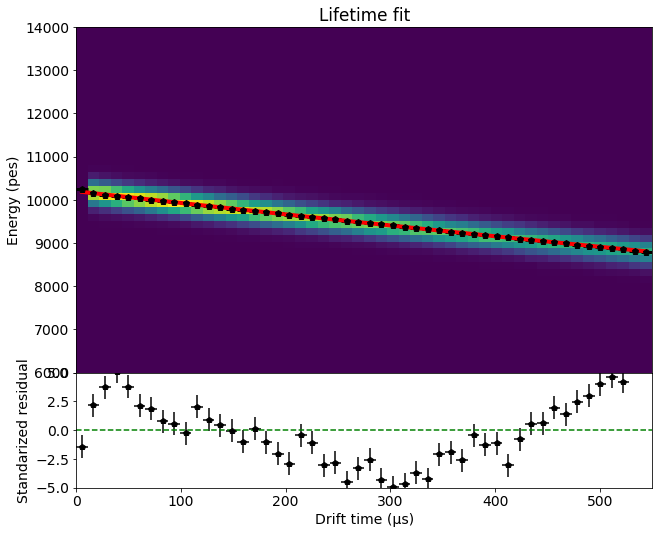

In [14]:
f = akr.lt(Z[sel], E[sel], Znbins, Zrange, Enbins, Erange, plot = True);
print('e0, lt  (binned) ', f.values, 'chi2', f.chi2)

## lifetime in R vs time

In [15]:
Ta = hst.Vaxis((TH.min(), TH.max()), step = delta_time/2.)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


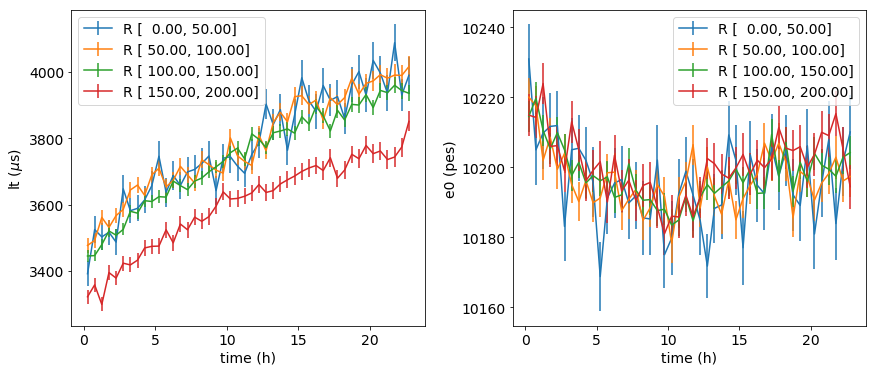

In [16]:
Ra = hst.Vaxis((0., 200), nbins = 4)
fs = akr.lt_vs_t_vs_v_lsqfit(Z[sel], E[sel], TH[sel], R[sel], Ta.bins, Ra.bins, nbins = 22)
apt.plt_lt_vs_t_vs_v(fs, Ra.bins, Ta.centers, 'R')

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


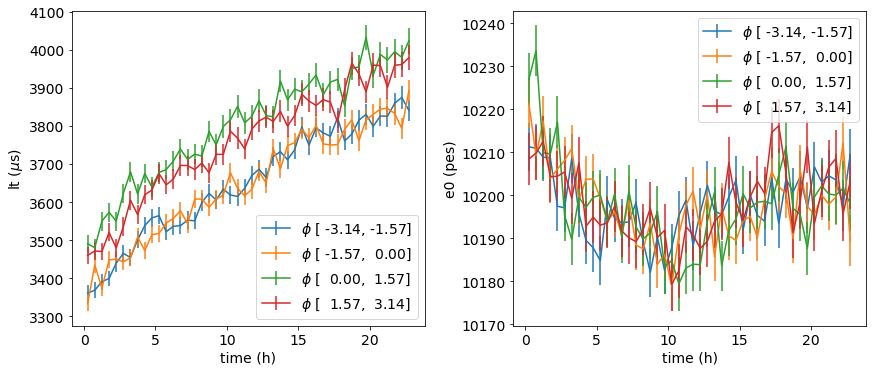

In [17]:
Phia = hst.Vaxis( (-np.pi, np.pi), nbins = 4)
fs = akr.lt_vs_t_vs_v_lsqfit(Z[sel], E[sel], TH[sel], Phi[sel], Ta.bins, Phia.bins, nbins = 22)
apt.plt_lt_vs_t_vs_v(fs, Phia.bins, Ta.centers,'$\phi$')

## Study map in time slices

In [18]:
XYa = hst.Vaxis( XYrange, nbins = XYnbins_fine)

In [19]:
xye0, xylt, xychi2, xyok = akr.ltmap_lsqfit(X[sel], Y[sel], Z[sel], S2e[sel], XYa.bins)

/Users/hernando/investigacion/NEXT/work/KrCalib/krcal/dev/akr_functions.py:203: RuntimeWarning: divide by zero encountered in true_divide
  res = (a*xs[cok]+b-ys[cok])/uys[cok]


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


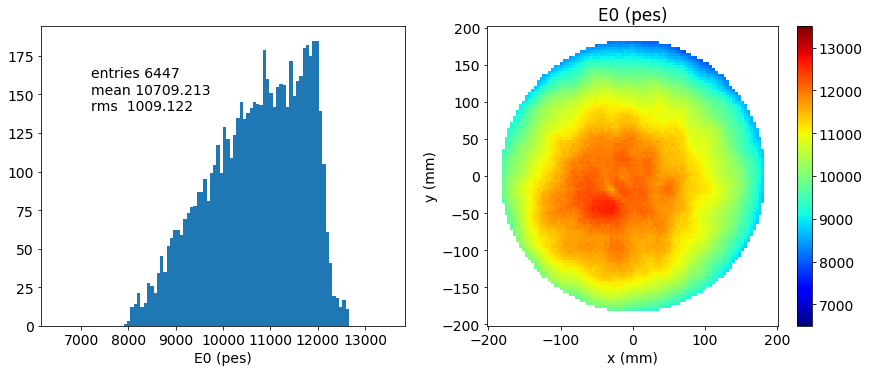

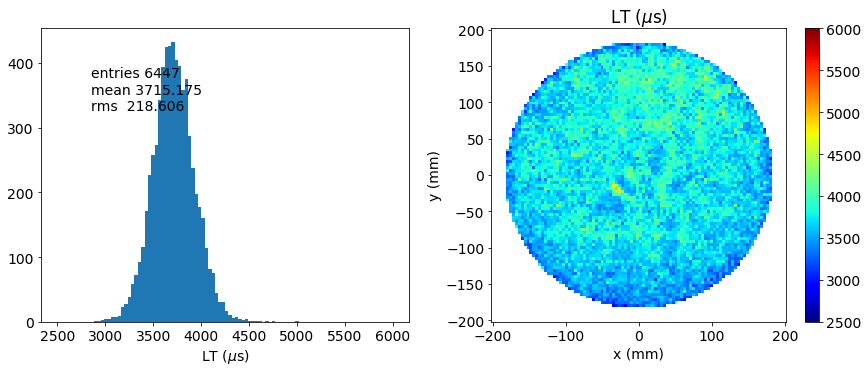

In [20]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
apt.plt_xymap(XYa.centers, XYa.centers, xye0.value, xyok, XYa.nbins, E0range, 'E0 (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xylt.value, xyok, XYa.nbins, LTrange, 'LT ($\mu$s)');

In [21]:
Ta  = hst.Vaxis((TH.min(), TH.max()), step = delta_time)
XYa = hst.Vaxis( XYrange, XYnbins)

In [22]:
fs = akr.ltmap_vs_t_lsqfit(X[sel], Y[sel], Z[sel], S2e[sel], TH[sel], XYa.bins, Ta.bins) 

In [23]:
def str_tbin(i):
    return 'T ['+str(Ta.bins[i])+', '+str(Ta.bins[i+1])+'] (h)'

In [24]:
xye0s   = [fi[0] for fi in fs]
xylts   = [fi[1] for fi in fs]
xychi2s = [fi[2] for fi in fs]
xyoks   = [fi[3] for fi in fs]

## E0 and LT map evolution

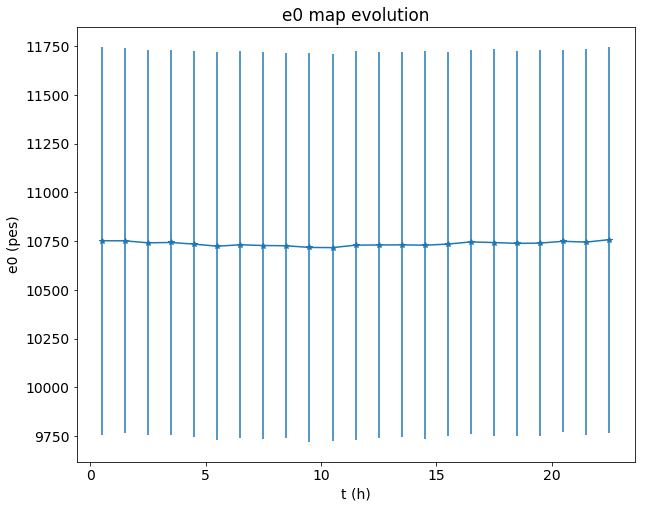

In [25]:
vals = [akr.xymap_mean_std(xye0i.value, xyoki) for xye0i, xyoki in zip(xye0s, xyoks)]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Ta.centers, ms, us, fmt='-*');
plt.xlabel('t (h)'); plt.ylabel('e0 (pes)'); plt.title('e0 map evolution');

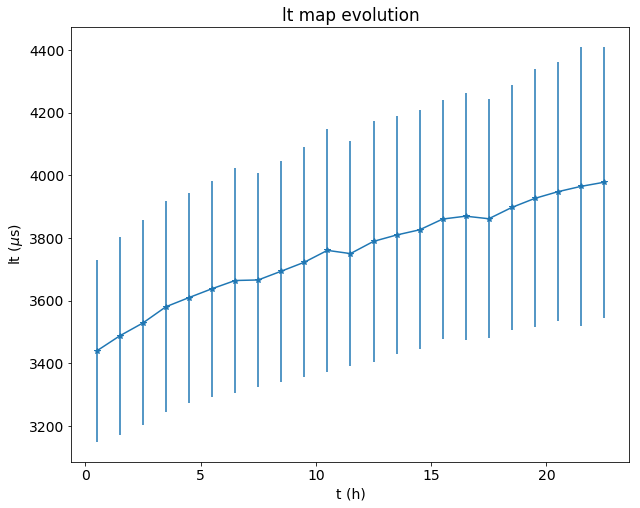

In [26]:
vals = [akr.xymap_mean_std(xylti.value, xyoki) for xylti, xyoki in zip(xylts, xyoks)]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Ta.centers, ms, us, fmt='-*');
plt.xlabel('t (h)'); plt.ylabel('lt ($\mu$s)'); plt.title('lt map evolution');

## Pull evolution respect the first map

In [27]:
de0s = [akr.xymap_compare(xye0s[i], xye0s[0], xyoks[i], xyoks[0], type = 'pull') for i in range(1, Ta.nbins)]
dlts = [akr.xymap_compare(xylts[i], xylts[0], xyoks[i], xyoks[0], type = 'pull') for i in range(1, Ta.nbins)]

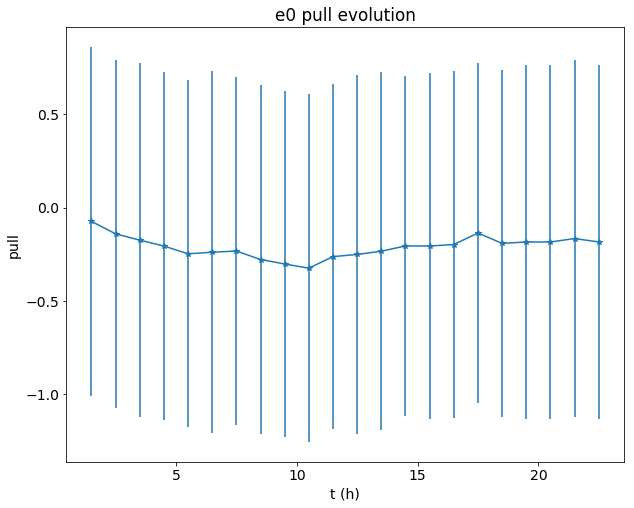

In [28]:
vals = [akr.xymap_mean_std(di[0].value, di[1]) for di in de0s]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Ta.centers[1:], ms, us, fmt='-*');
plt.xlabel('t (h)'); plt.ylabel('pull'); plt.title('e0 pull evolution'); 

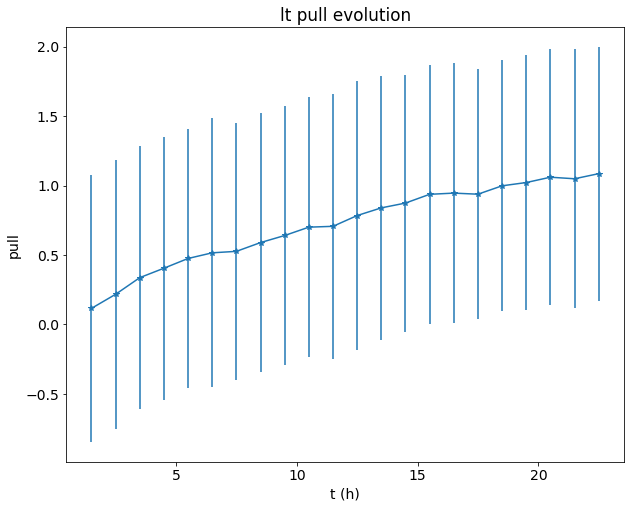

In [29]:
vals = [akr.xymap_mean_std(di[0].value, di[1]) for di in dlts]
ms, us = [ival[0] for ival in vals], [ival[1] for ival in vals]
plt.errorbar(Ta.centers[1:], ms, us, fmt='-*');
plt.xlabel('t (h)'); plt.ylabel('pull'); plt.title('lt pull evolution'); 

## Movies

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this wa

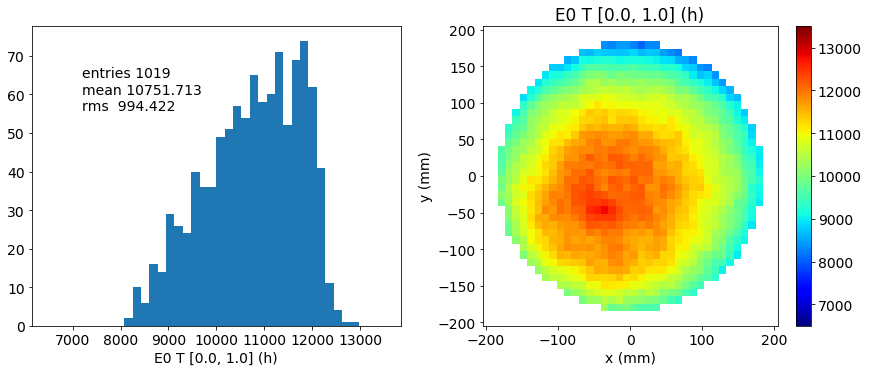

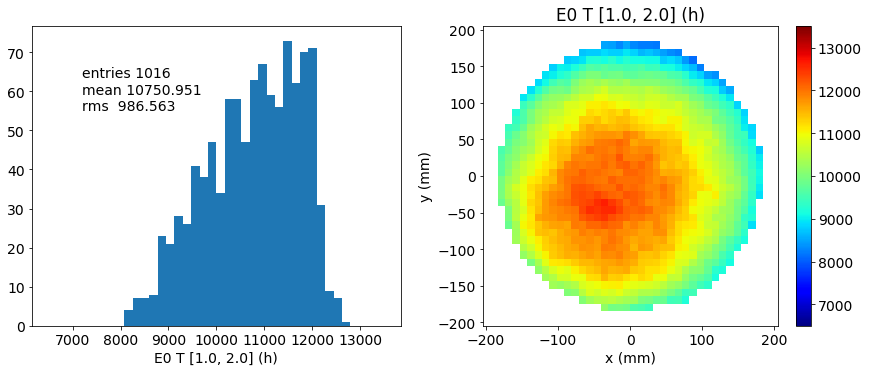

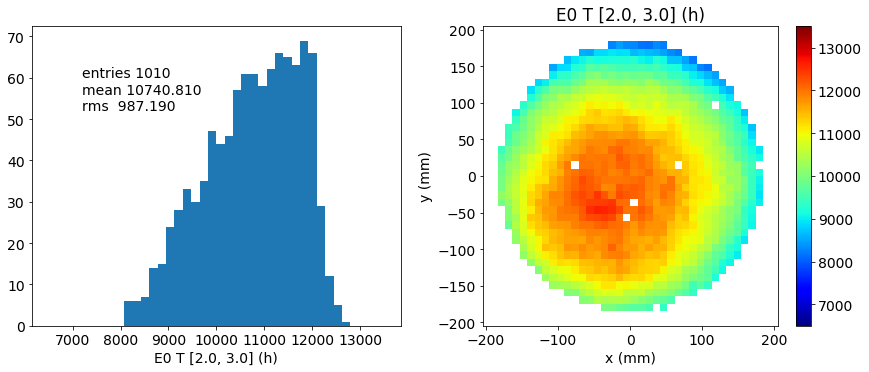

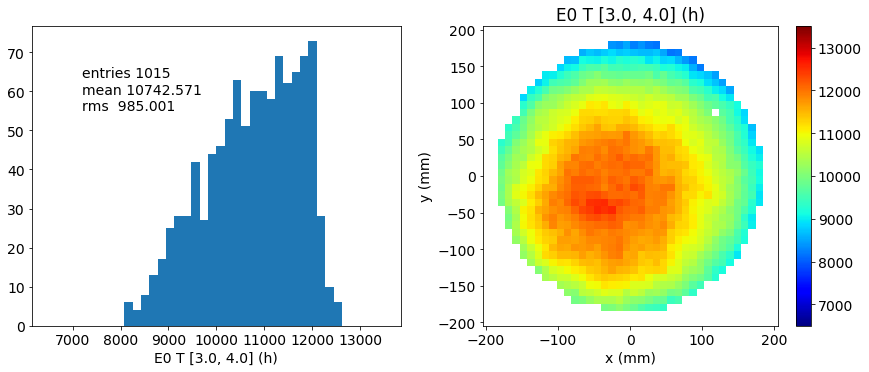

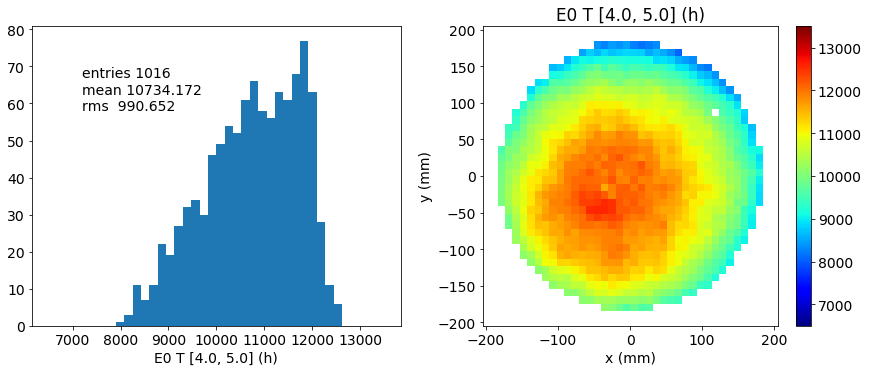

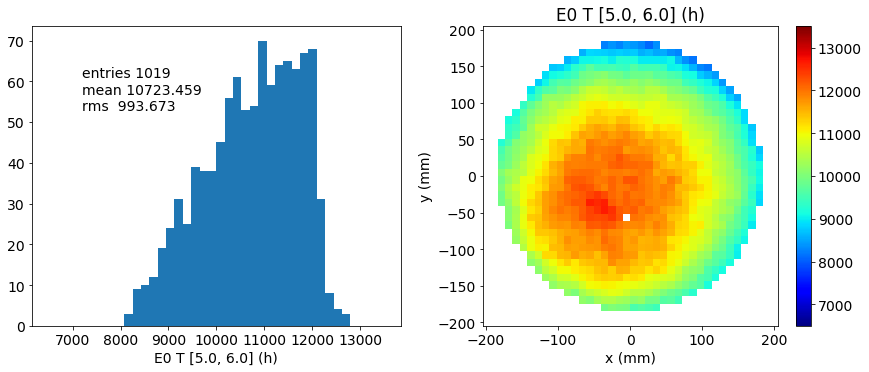

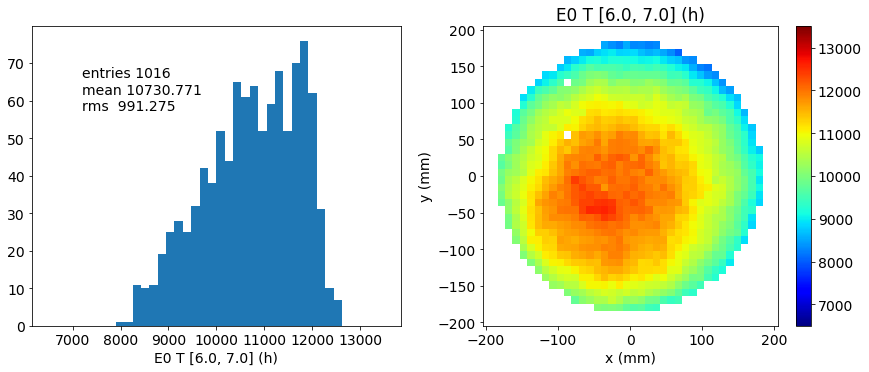

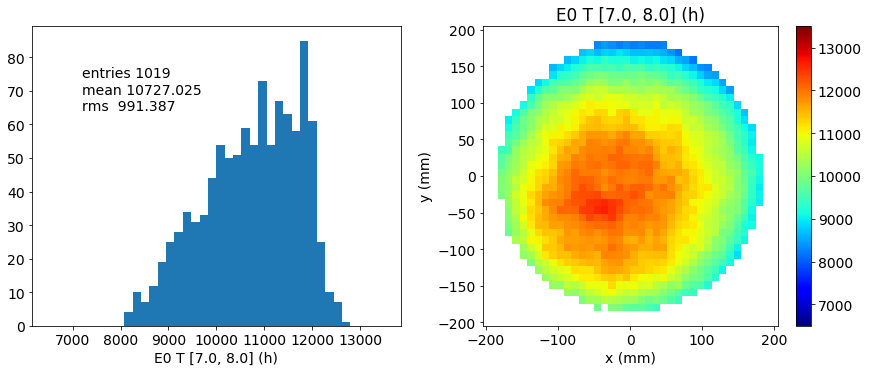

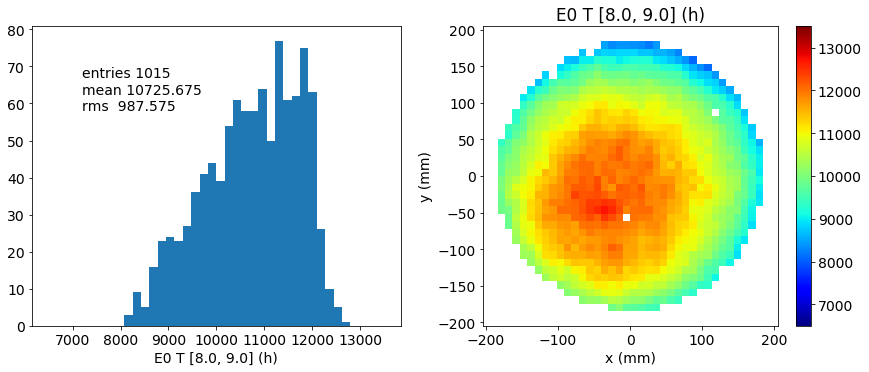

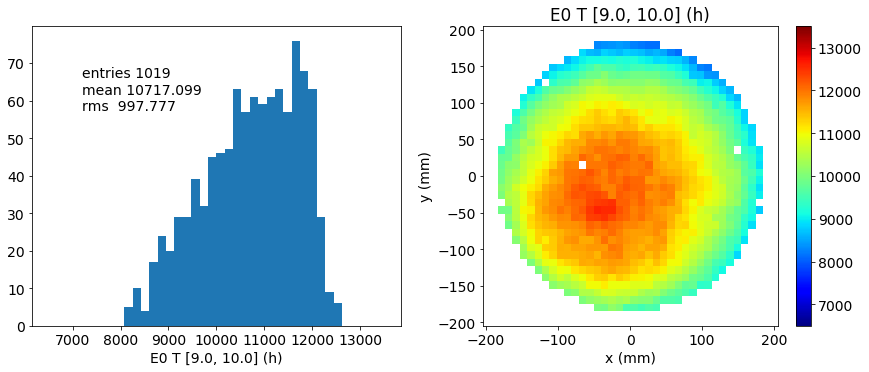

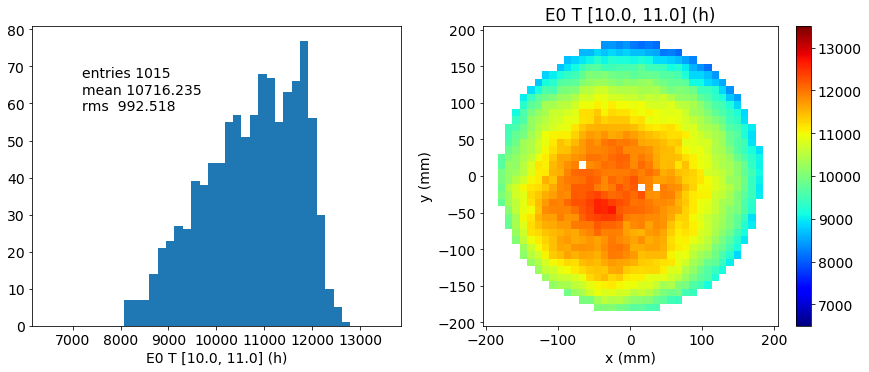

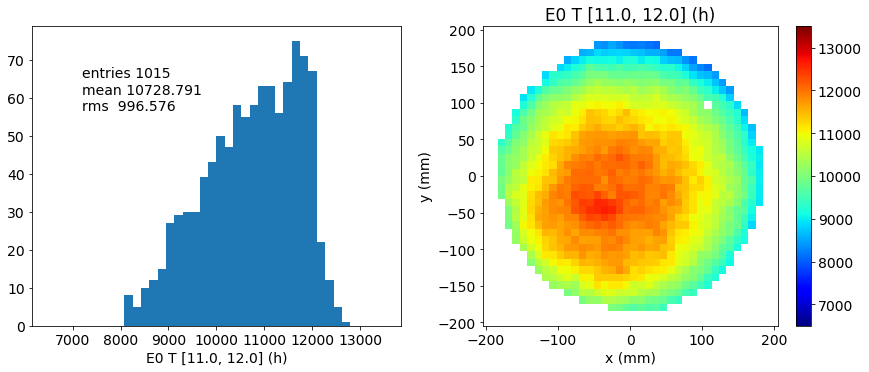

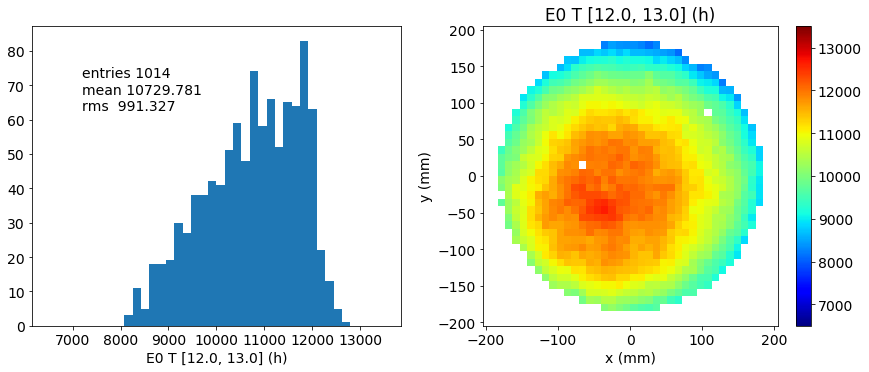

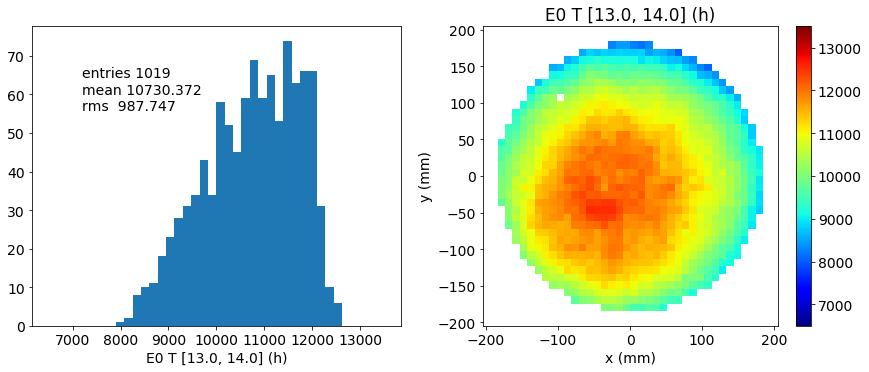

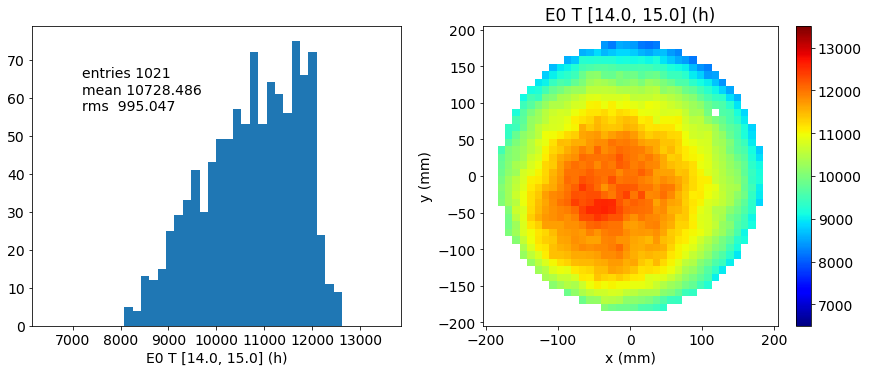

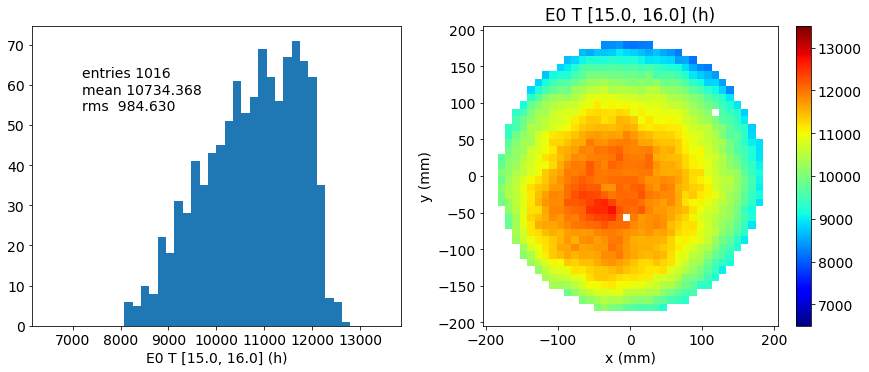

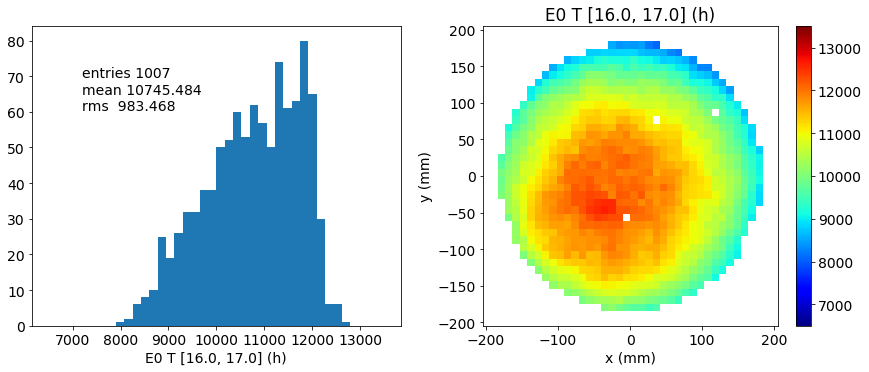

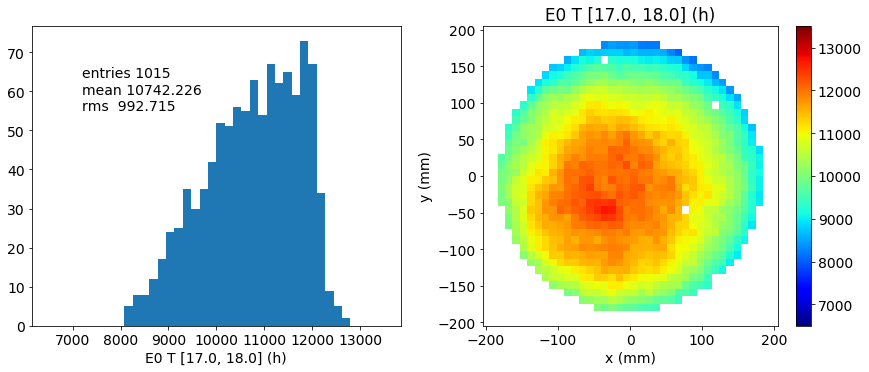

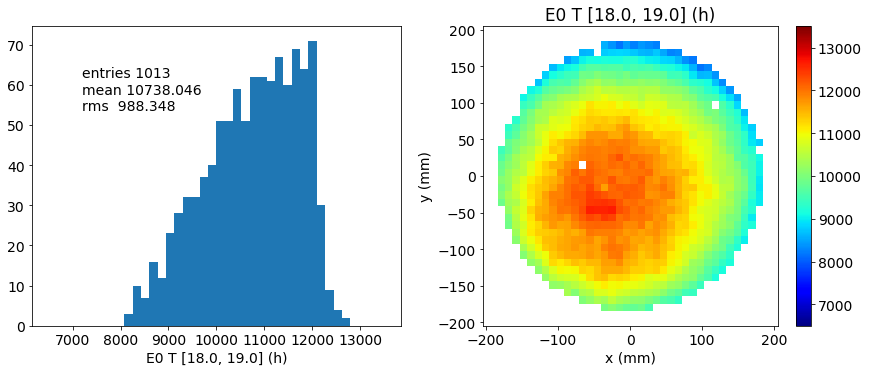

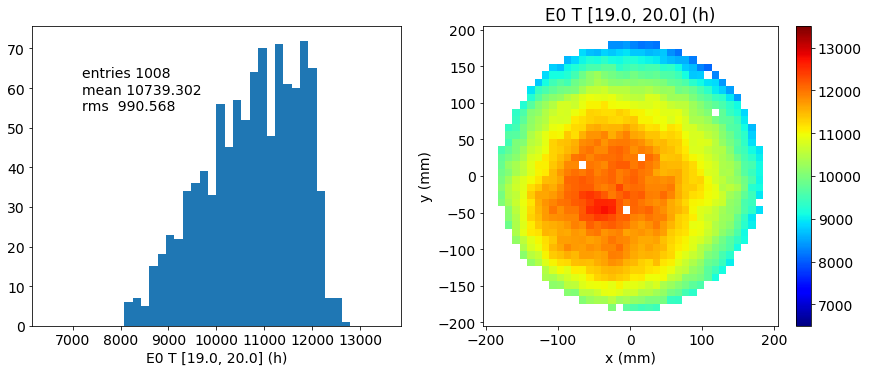

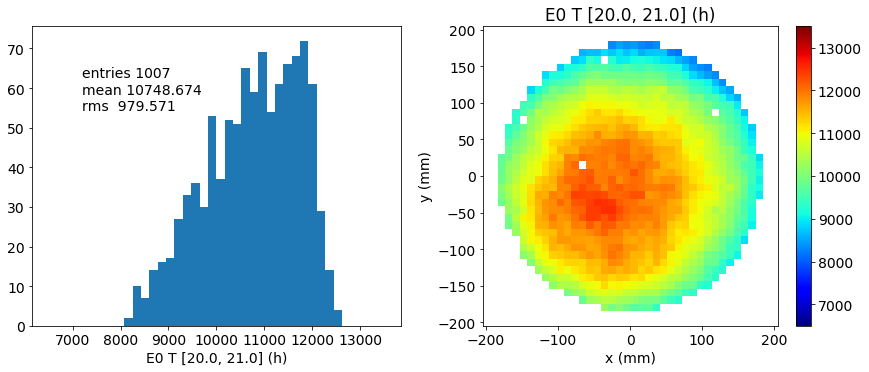

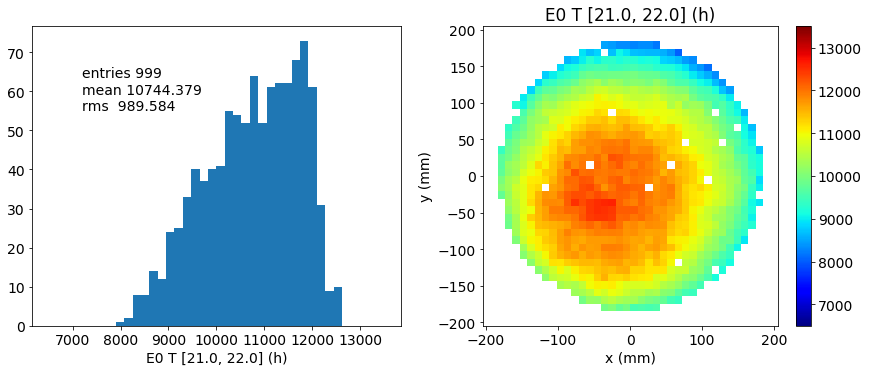

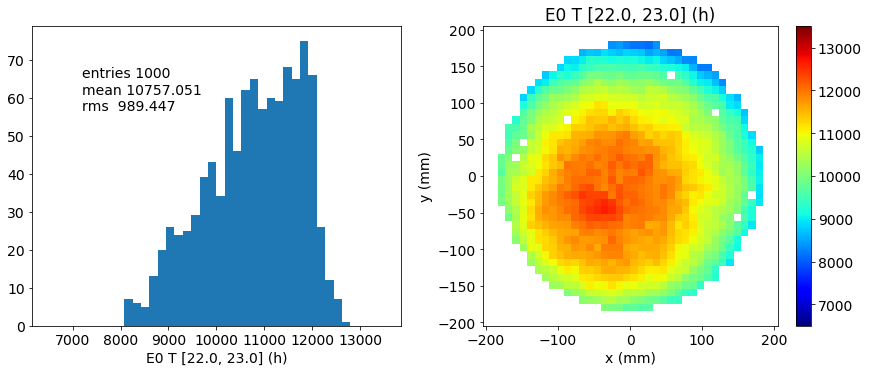

In [30]:
if (make_movie):
    for i in range(Ta.nbins):
        label = 'plots/run'+str(run_number)+'e0'
        apt.plt_xymap(XYa.centers, XYa.centers, xye0s[i].value, xyoks[i], XYa.nbins, E0range,
                      label='E0 '+str_tbin(i))
        fig = plt.gcf()
        fig.savefig(label+str(i)+'.png')
    mv.movie(label, Ta.nbins)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this wa

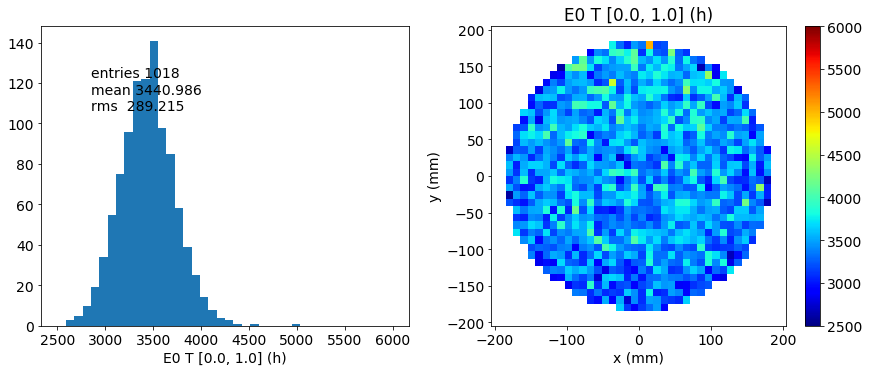

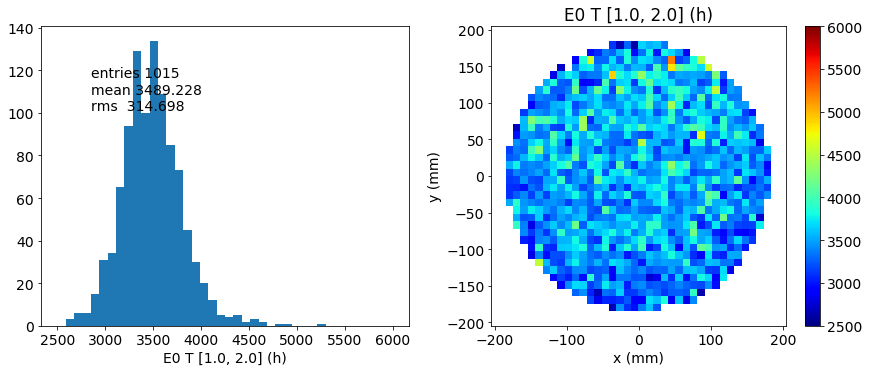

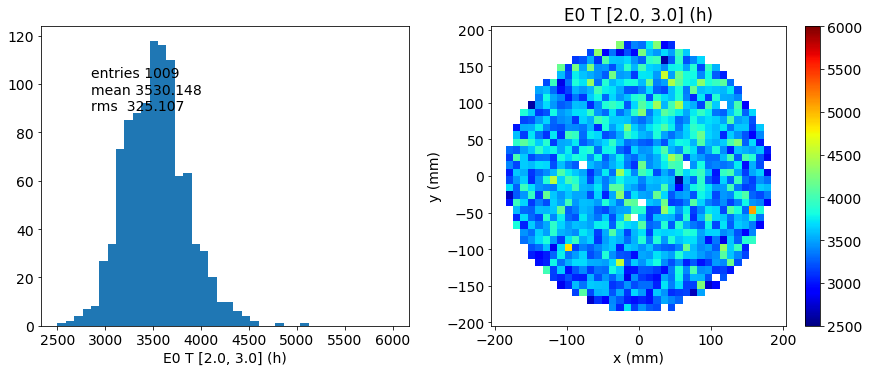

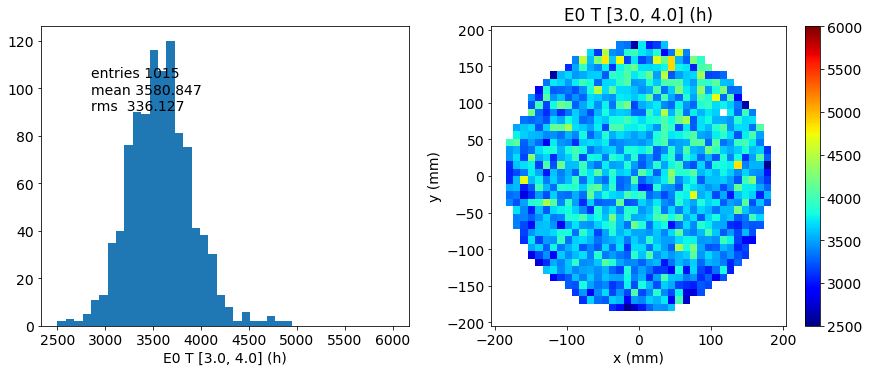

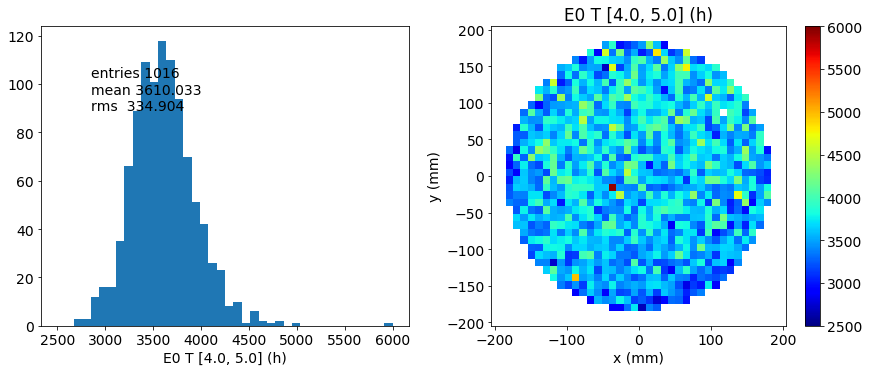

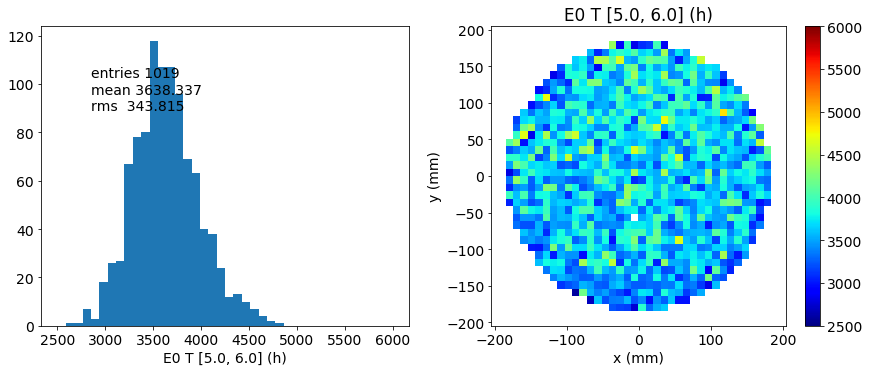

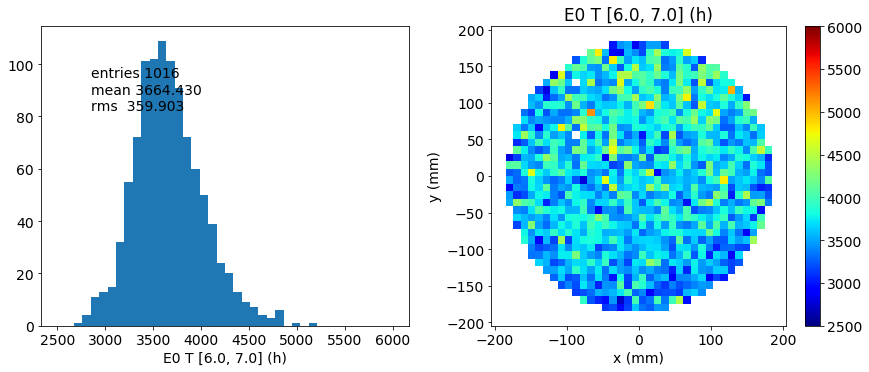

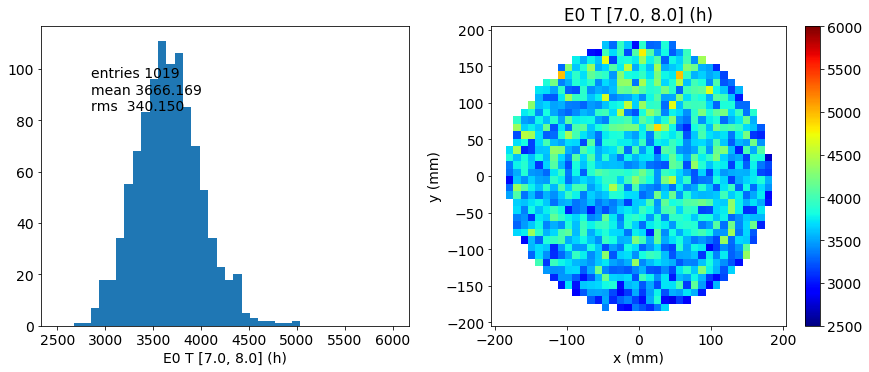

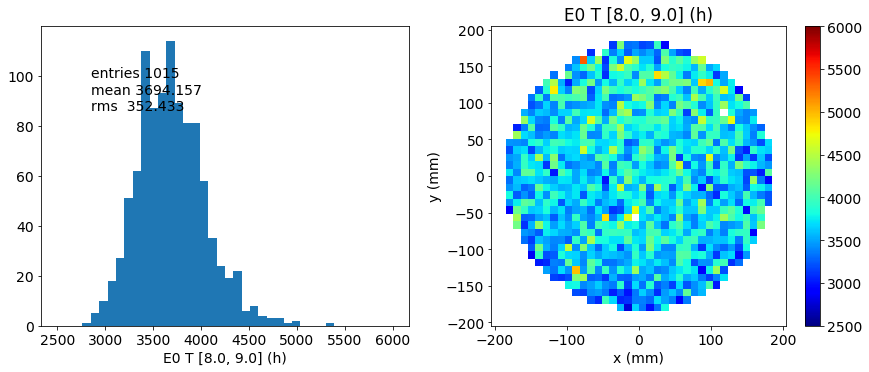

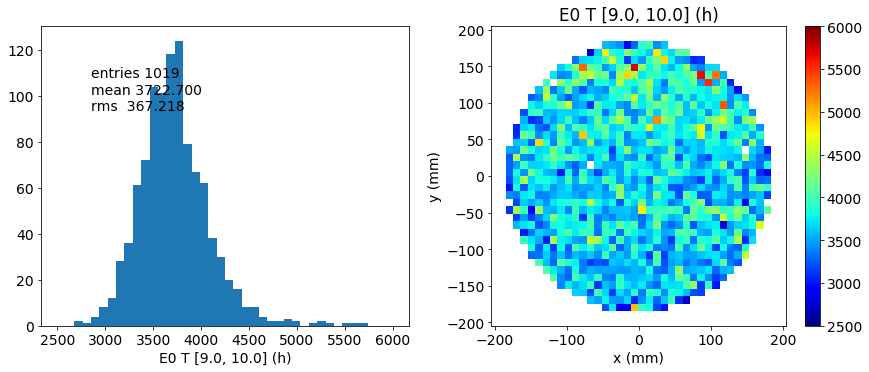

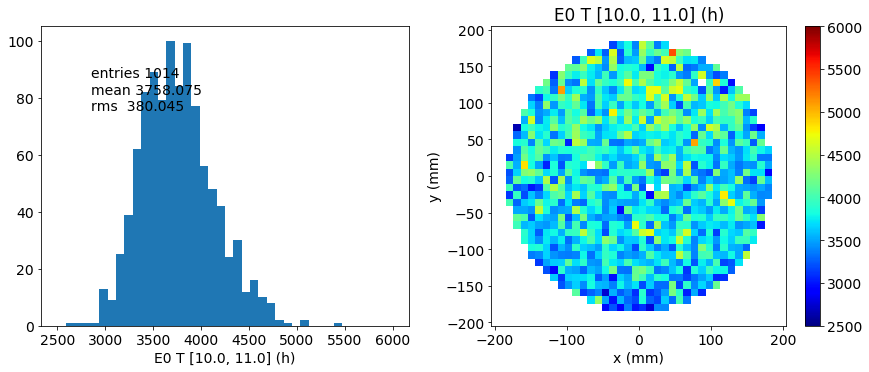

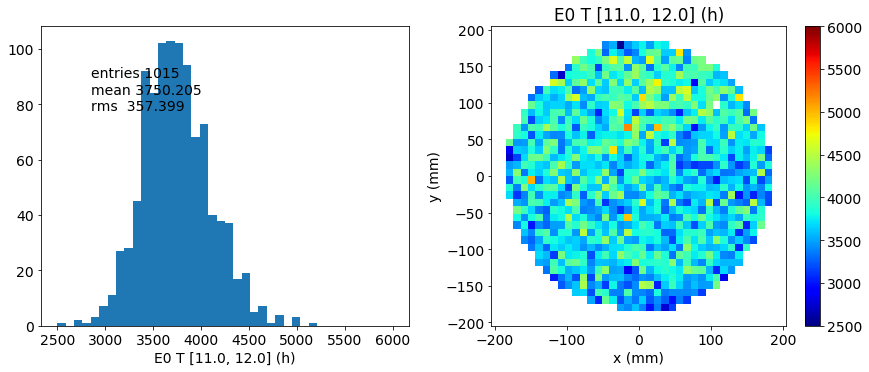

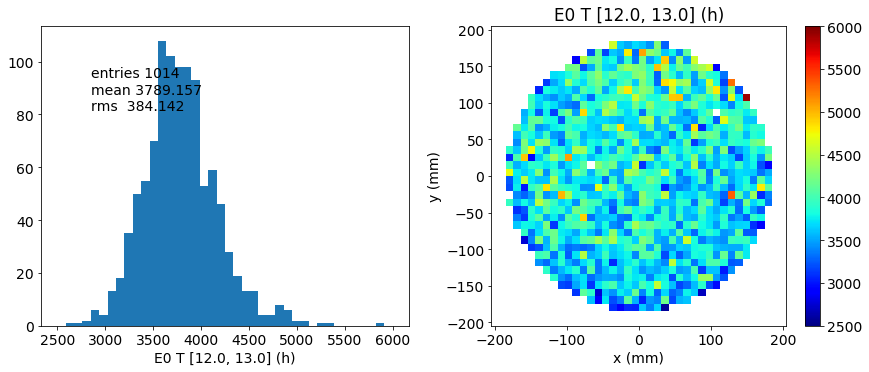

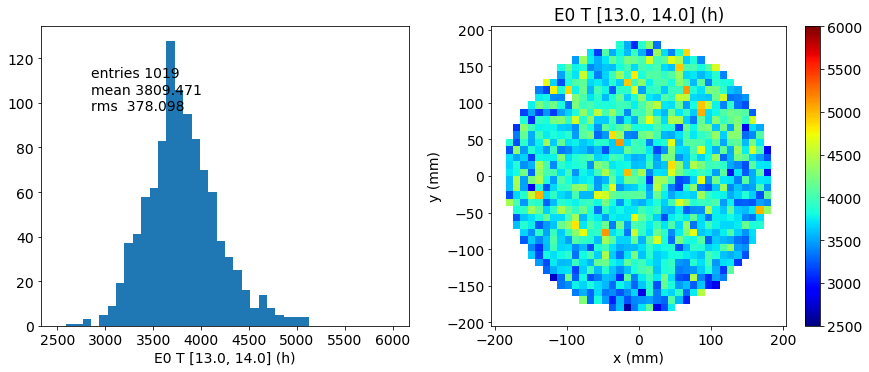

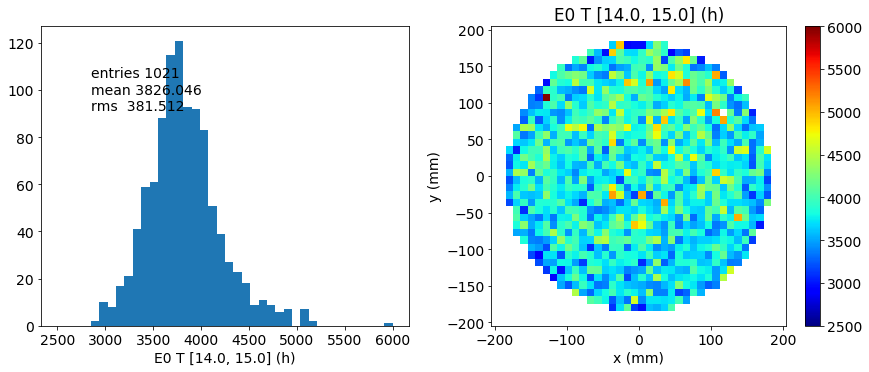

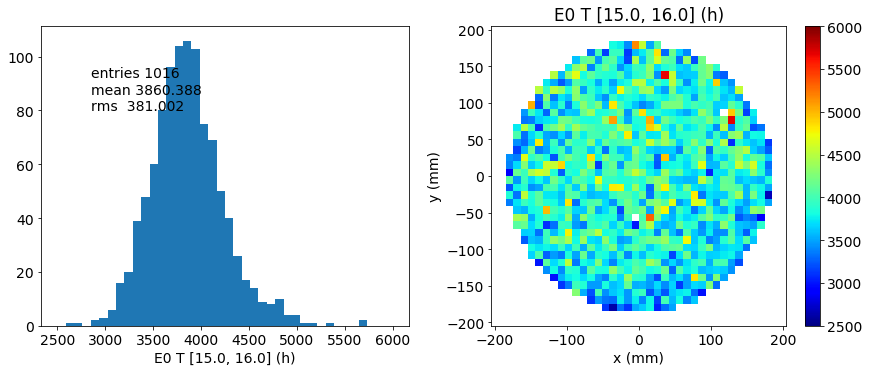

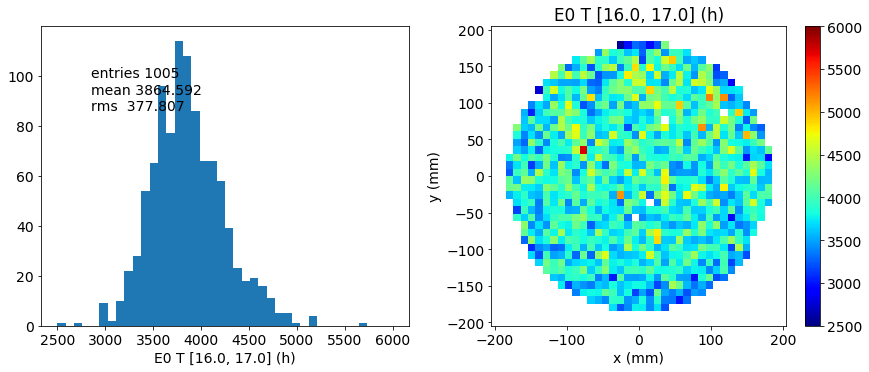

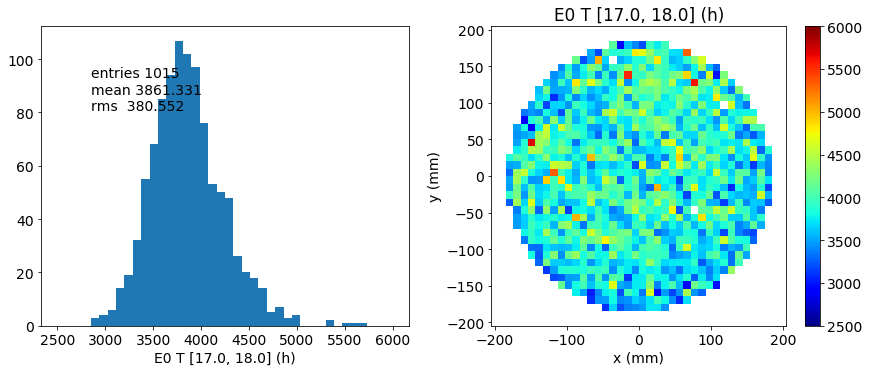

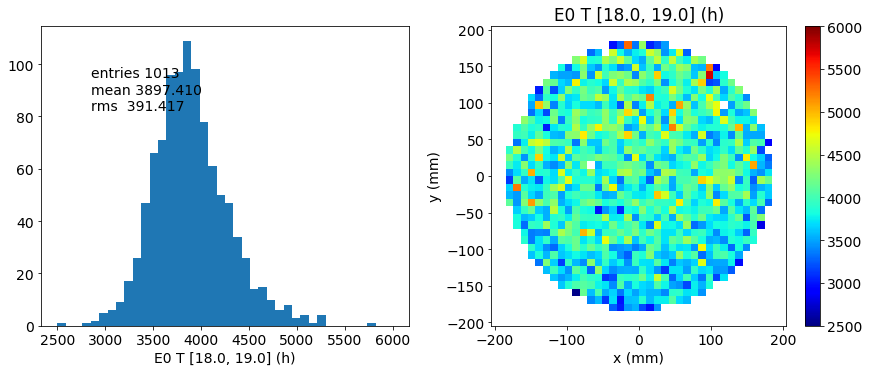

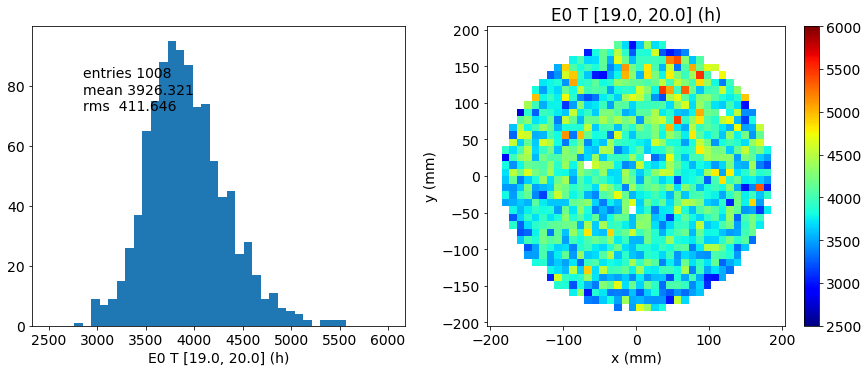

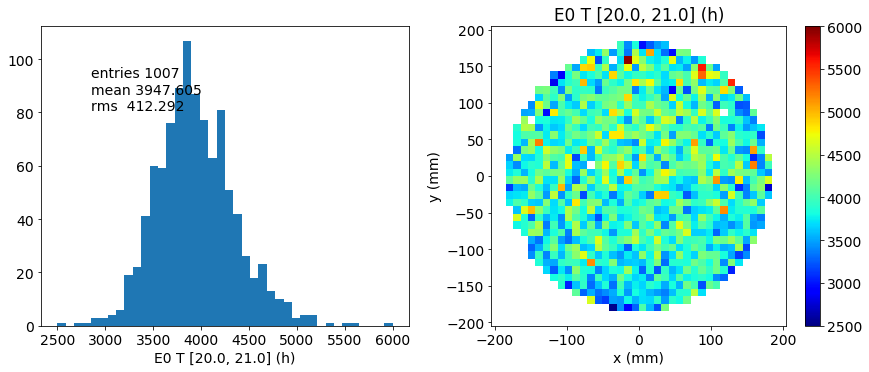

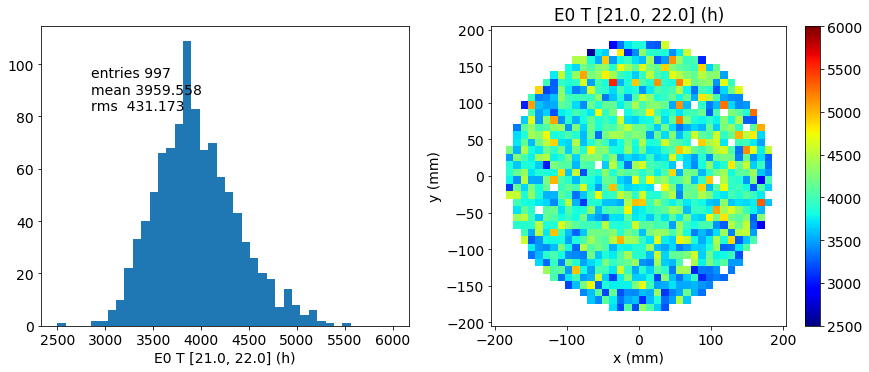

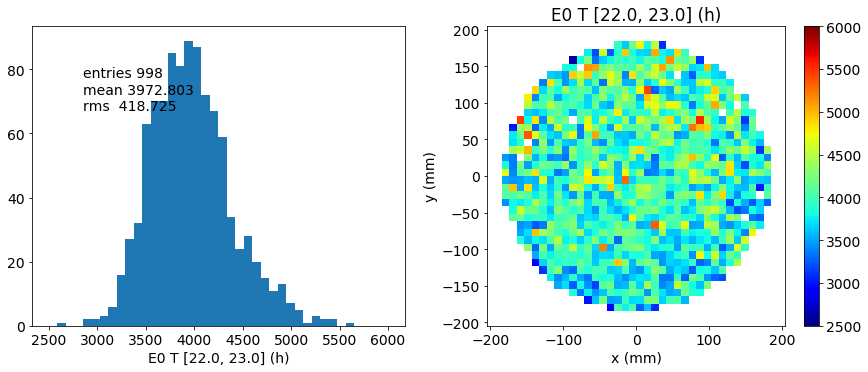

In [31]:
if (make_movie):
    for i in range(Ta.nbins):
        label = 'plots/run'+str(run_number)+'lt'
        apt.plt_xymap(XYa.centers, XYa.centers, xylts[i].value, xyoks[i], XYa.nbins, LTrange,
                      label='E0 '+str_tbin(i))
        fig = plt.gcf()
        fig.savefig(label+str(i)+'.png')
    mv.movie(label, Ta.nbins)

In [32]:
print('Done!')

Done!
